# Baseline Model in python

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from sklearn.preprocessing import StandardScaler
from scipy.special import logit
from sklearn.metrics import accuracy_score, log_loss as cross_entropy_score

In [6]:
from numpy.random import default_rng
rng = default_rng(seed=1234)

In [8]:
from masterthesis.data import load_h5ad

# load the python AnnData object
acinar_ann = load_h5ad("/home/julian/Uni/MasterThesis/data/acinar_sce.h5ad")

In [9]:
print("Dataset shape", acinar_ann.X.shape)
print("First gene:", acinar_ann.X[:,0].shape)

Dataset shape (411, 23368)
First gene: (411,)


In [10]:
# Access Gene Names
acinar_ann.var_names

Index(['1/2-SBSRNA4', 'A1BG', 'A1BG-AS1', 'A1CF', 'A2LD1', 'A2M', 'A2ML1',
       'A2MP1', 'A4GALT', 'A4GNT',
       ...
       'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1',
       'ZZZ3', 'tAKR'],
      dtype='object', length=23368)

In [11]:
# select one gene
acinar_ann[:, acinar_ann.var_names.str.match("A1CF")]

View of AnnData object with n_obs × n_vars = 411 × 1
    obs: 'wellKey', 'geo_accession', 'donor_age', 'gender', 'inferred_cell_type'
    var: 'primerid'
    uns: 'X_name'
    layers: 'counts', 'tpm'

### R Gene selection and Test Split

In [12]:
# sampling in R with seed 1234
test_idx = [284, 336, 406, 101, 111, 393, 133, 400, 388, 98, 103, 214, 90, 326, 79, 372, 270, 382, 184, 62, 4, 403, 149, 40, 212, 195, 93, 122, 66, 175, 379, 304, 108, 131, 343, 41, 115, 228, 328, 298, 299]
train_idx = list(set(range(acinar_ann.X.shape[0])) - set(test_idx))

In [13]:
# selected Genes after preprocessing in R
sel_genes = ["REG3A", "AMY2A", "MT2A", "OLFM4",
             "SYCN", "CELA2B", "FGL1", "AMY2B",
             "MT1G", "TM4SF1", "CELA2A", "PDK4", 
             "TACSTD2", "CD44", "PNLIPRP2", "ALB", 
             "ERP27", "LDHA", "REG3G", "CTRL", "CLPS",
             "FOS", "HSPA8", "SERPINA3", "CELA3B", "CRP" ]

sel_genes = sorted(sel_genes)

In [14]:
from sklearn.model_selection import train_test_split

y = np.array([int(x) for x in acinar_ann.obs.donor_age])
k = len(np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(acinar_ann[:,sel_genes].X, y, 
                                                    test_size=0.1, 
                                                    stratify=y,
                                                    random_state=1234)

In [15]:
# old approach based on the indexes from R
#y_train = y[train_idx]
#y_test = y[test_idx]

#X_train = acinar_ann[test_idx, sel_genes].X
#X_test = acinar_ann[train_idx, sel_genes].X

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [17]:
print("Test X:", X_test.shape)
print("Test y:", y_test.shape)
print("Train X:", X_train.shape)
print("Train y:", y_train.shape)

Test X: (42, 26)
Test y: (42,)
Train X: (369, 26)
Train y: (369,)


## Model 1: mord

**Result: It was not possible to achieve the necessary sparsity with this model. Only L2 regularization is required. The thresholds seem not entirely plausible**

[Reference 1](https://medium.datadriveninvestor.com/logistic-regression-simple-multinomial-and-ordinal-b2bc886bb974) [Reference 2](https://pythonhosted.org/mord/)

In [18]:
#!pip install mord

In [19]:
from mord import LogisticAT, LogisticIT

In [20]:
# Transform y into a series of subsequent labels [0,1,2 ...]
transf = dict(zip(np.unique(y),
                  np.arange(0, len(np.unique(y)))))
                        
y_train_trans = np.array([transf[e] for e in y_train])
y_test_trans = np.array([transf[e] for e in y_test])

# reordering, such that yi < yi+1
train_reorder = np.argsort(y_train_trans)
test_reorder = np.argsort(y_test_trans)

In [21]:
# all-threshold fit
regressor = LogisticAT(verbose=0, alpha=0.1)
regressor.fit(X_train, y_train_trans)
regressor.score(X_test, y_test_trans)

-1.2619047619047619

In [22]:
# immediate-threshold fit
regressor = LogisticIT(verbose=0, alpha=0, )
regressor.fit(X_train[train_reorder], y_train_trans[train_reorder])
regressor.score(X_test[test_reorder], y_test_trans[test_reorder])

0.38095238095238093

In [ ]:
regressor.coef_

In [ ]:
regressor.theta_

## Model 2: Ordered Multinomial Regression (statsmodels) 

**Result: Introducing sparsity, or even using any regularizer seems to not be supported, or at least I didn't find a way.**

In [ ]:
import scipy.stats as stats
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [ ]:
mod_prob = OrderedModel(y_train,
                        X_train,
                        distr='logit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary().tables[0]

In [ ]:
res_prob.params

In [ ]:
predictions = res_prob.model.predict(res_prob.params, exog=X_test)
print("Predictions:", predictions.argmax(1))
print("Ground Truth:", y_test_trans)
print("Cross Entropy:", cross_entropy_score(y_test, predictions, labels=np.unique(y)))
print("Accuracy:", accuracy_score(predictions.argmax(1), y_test_trans))

## Model 3: Multinomial Regression (sklearn)

**Results:** 
- Introduction of sparsity worked well with the l1 penalty
- Prediction results were on par with the other methods
- However, since this is solved as a multinomial regression problem, one set of parameters is fit for each prediction class. This introduces a new problem for selection of parameters: The weights have to be aggregated, which has eliminated the sparsity with the attempted approaches.

In [47]:
from sklearn.linear_model import LogisticRegression

sk_model = LogisticRegression(penalty="l1",
                              multi_class="multinomial", # "auto", "ovr", "multinomial"
                              solver="saga",
                              random_state=12345)
sk_model.fit(X_train, y_train)

/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(multi_class='multinomial', penalty='l1', random_state=12345,
                   solver='saga')

In [48]:
print("Model coefficients shape:", sk_model.coef_.shape)
print("Train score:", sk_model.score(X_train, y_train))
print("Test score:", sk_model.score(X_test, y_test))

Model coefficients shape: (8, 26)
Train score: 0.9512195121951219
Test score: 0.8333333333333334


#### Aggregation of Weights from multinomial model


In [49]:
# defines a threshold below which a gene is not considered significant
# this is arbitrary, there is no way of defining this
sparsity_threshold = 0.0001

skl_mm_added = np.add.reduce(sk_model.coef_, axis=0)
print("Added weights from Muli-Class model")
print("sparsity:", sum(np.abs(skl_mm_added) < sparsity_threshold))

skl_mm_mean = skl_mm_added / sk_model.coef_.shape[1]
print("Average weights from Muli-Class model")
print("sparsity:", sum(np.abs(skl_mm_mean) < sparsity_threshold))

Added weights from Muli-Class model
sparsity: 0
Average weights from Muli-Class model
sparsity: 0


## Models 4-6: Binary LogisticRegression (sklearn)

### Convert the data

- The labels are converted to binary, such that the threshold from 0-1 corresponds from changing from label $l_i$ to $l_{i+1}$. $k$ copies of the label vector are concatenated such that for every vector $j$ the labels  $l_i$ with $i<j$ are converted to 0 and the labels $i\ge j$ are converted to 1.
- The count matrix is extended with copies of itself, to fit the converted label vector FOR NOW. For big problems, it could suffice to have just one label vector and perform and iterative training.
- To train the thresholds, $k$ columns are added to the count matrix and initialized to zero. Each column column represents the threshold for a label $l_i$ and is set to 1, exactly  where that label $l_1$ occurs.

In [23]:
def to_bin_y(y_orig):
    y_classes = np.unique(y_orig)
    k = len(y_classes)

    y_bin = []
    for ki in range(1,k):
        thresh = y_classes[ki]
        # forward
        y_bin += [int(x >= thresh) for x in y_orig]

    y_bin = np.array(y_bin)
    
    return y_bin 

In [24]:
def to_bin_X(X_orig, k):

    # X training matrix
    X_bin = np.concatenate([X_orig.copy()] * (k-1))
    # Add thresholds
    num_el = X_orig.shape[0] * (k-1)

    for ki in range(k-1):
        temp = np.repeat(0, num_el).reshape(X_orig.shape[0], (k-1))
        temp[:,ki] = 1
        if ki > 0:
            thresholds = np.concatenate([thresholds, temp])
        else:
            thresholds = temp

    X_bin = np.concatenate([X_bin, thresholds], axis=1)

    return X_bin

In [25]:
y_train_bin = to_bin_y(y_train)
print("y_train:", len(y_train_bin))

y_test_bin = to_bin_y(y_test)
print("y_test:", len(y_test_bin))

y_train: 2583
y_test: 294


In [26]:
X_train_bin = to_bin_X(X_train, k=np.unique(y).size)
print("X_train_bin:", X_train_bin.shape)

X_test_bin = to_bin_X(X_test, k=np.unique(y).size)
print("X_test_bin:", X_test_bin.shape)

X_train_bin: (2583, 33)
X_test_bin: (294, 33)


### Model 4: LogisticRegression (sklearn)

In [50]:
from sklearn.linear_model import LogisticRegression

sk_binlogreg_model = LogisticRegression(penalty="l1", 
                                  fit_intercept=False,
                                  max_iter=10000,
                                  solver="liblinear",
                                  random_state=1234567,
                                  C=0.1  # Inverse of regularization strength -> controls sparsity in our case!
                                 )

sk_binlogreg_model.fit(X_train_bin, y_train_bin)

LogisticRegression(C=0.1, fit_intercept=False, max_iter=10000, penalty='l1',
                   random_state=1234567, solver='liblinear')

In [51]:
print("Train score:",sk_binlogreg_model.score(X_train_bin, y_train_bin))
print("Test score:",sk_binlogreg_model.score(X_test_bin, y_test_bin))

Train score: 0.8726287262872628
Test score: 0.8163265306122449


In [52]:
sk_binlogreg_model.coef_

array([[ 0.18338494,  0.08959136,  0.41162076,  0.4101795 ,  0.        ,
        -0.51106718,  0.4666131 , -0.16120057,  0.        , -0.4989468 ,
        -0.39934436,  0.08447766, -0.14264743, -0.05664298,  0.        ,
         0.        ,  0.48957066,  0.03816799,  0.32179104, -0.21822623,
         0.59600626, -0.37124937,  0.73135775,  0.18796087, -0.33125337,
         0.07321899,  2.53029101,  0.43882321,  0.        , -0.91536584,
        -1.07835296, -2.55382416, -3.05172188]])

## Binary Logistic Regression with GLMnet

In [ ]:
#!pip install --upgrade glmnet

In [ ]:
#!pip install glment-py

* The originally used package `glment` no longer works
* glmnet_py

In [ ]:
#from glmnet import LogitNet

## Note: Alpha is the regularization mixing parameter: alpha=1 -> L1, alpha=0 -> L2, 0<alpha<1 -> elastic net 
#glmnet_model = LogitNet(alpha=1,
#                        fit_intercept=False,
#                        standardize=False, # already standardized
#                        random_state=1234,
#                        max_iter=10000)
#glmnet_model.fit(X_train_bin, y_train_bin)

In [ ]:
#print("Train score: ", glmnet_model.score(X_train_bin, y_train_bin))
#print("Test score: ", glmnet_model.score(X_test_bin, y_test_bin))

In [ ]:
#glmnet_model.coef_

## SGD with mini Batches

To reduce the memory load, this introduces a sampling method with an iterative training paradigm

ToDo: 

    - Construct matrix on the fly
    - Check convergence / early stopping
    

In [30]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(loss="log_loss",
                          penalty="l1",
                          alpha=0.0124,  # = lambda in paper!! Very important to tune for the desired sparsity!
                          fit_intercept=False,
                          n_jobs=1)

cur_iter = 0
max_iter = 10
n_batches = 2

while cur_iter < max_iter:
    if (cur_iter > 0 and cur_iter % 2 == 0):
        print("Iter: ", cur_iter, "Train score: ", sgd_model.score(X_batch, y_batch))
    
    cur_iter += 1
    
    # fit from samples of the big matrix
    # TODO: Sampling from the big matrix directly is just for PoP,
    # and eliminates the purpose. Only the binarized y-vector should
    # be created and the indexes taken from the log count matrix.
    sampled_indices = np.random.randint(X_train_bin.shape[0], size=X_train_bin.shape[0])

    start = 0
    for i in range(1, n_batches+1):
        end = (i * X_train_bin.shape[0] // n_batches)
        idx = sampled_indices[start:end]
        X_batch = X_train_bin[idx,:]
        y_batch = y_train_bin[idx]
        start = end
        sgd_model.partial_fit(X_batch, y_batch, classes=np.unique(y_batch))

Iter:  2 Train score:  0.8397832817337462
Iter:  4 Train score:  0.8475232198142415
Iter:  6 Train score:  0.8475232198142415
Iter:  8 Train score:  0.8498452012383901


In [31]:
print("Train score:", sgd_model.score(X_train_bin, y_train_bin))
print("Test score:", sgd_model.score(X_test_bin, y_test_bin))

Train score: 0.8555942702284166
Test score: 0.7755102040816326


In [32]:
sgd_model.coef_

array([[ 0.06860807,  0.        ,  0.26104539,  0.18388071,  0.        ,
        -0.20935349,  0.00832072,  0.        ,  0.        , -0.22553307,
        -0.27649003,  0.03899763, -0.06279863, -0.025401  ,  0.        ,
         0.        ,  0.36290707,  0.        ,  0.24401225, -0.06078938,
         0.46763422, -0.29761353,  0.60563044,  0.        , -0.07044321,
         0.04767186,  1.61054271,  0.05154238,  0.        , -0.4318897 ,
        -0.60539077, -1.64943107, -2.11680081]])

# Compare Parameters

- To compare parameters we first fincd the best regularization strength
    * The best regularization has the highest score across 5-fold CV
    * To increase sparsity, we choose the parameter with highest regularization, that lies within 1 standard error of the optimum
- Then we do N fits with different seeds and collect the parameter values. 
- Finally we compare the distributions of the collected parameter values visually and wrt KL-divergence

The models to investigate:  sklearn LinRegressor, GLMnet Mmodel, SGD LinRegressor, and Psupertime


In [53]:
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV

n_folds = 3
kf = StratifiedKFold(n_splits=n_folds)

# elongate the origial non-binarized y-train data
# to enable stratification
y_train_elong = np.repeat(y_train, k-1)

cv_splits = kf.split(X_train_bin, y_train_elong)

In [54]:
from sklearn.metrics import accuracy_score, log_loss, make_scorer

scorers = {
    "accuracy": accuracy_score,
    "cross-entropy": log_loss
}

In [55]:
def dof(params):
    return np.count_nonzero(params != 0)

In [56]:
def cv_res_to_df(cv_results, scorers, reg_params=None):
    df = pd.DataFrame.from_dict(cv_results, orient="index").stack().to_frame()
    df = pd.DataFrame(df[0].values.tolist(), index=df.index)
    
    if reg_params is not None:
        df.columns = ["L=%s" % x for x in reg_params]

    for scorer in scorers.keys():
        df.loc[("mean", scorer), :] = df.xs(scorer, level=1).mean(axis=0)
    df.loc[("mean", "dof"), :] = df.xs("dof",level=1).mean(axis=0)
    
    return df.T
    

In [57]:
def find_optimal_param(res_df, reg_params, lower_increases_reg=True):
    trimmed = res_df.loc[res_df[("mean", "dof")] != 0]
    trimmed_max = trimmed[("mean", "accuracy")].max()
    trimmed_std = trimmed[("mean", "accuracy")].std()
    thresh = trimmed_max - trimmed_std
    above = trimmed[trimmed[("mean", "accuracy")] > thresh]

    if lower_increases_reg:
        idx = above.iloc[-1].name
    else:
        idx = above.iloc[0].name

    print("max:", trimmed_max, "std:", trimmed_std, "thresh:", thresh)
    print("Best average fit:", trimmed.loc[idx])
    print("Best parameter:", reg_params[idx])
    
    return reg_params[idx]        

**Important result: Choice of regularization path (lambda path) is critical for selection of best parameter!**

In [58]:
#reg_params = np.concatenate((np.linspace(1,5,10)[::-1], np.logspace(1, 15, 40, base=0.5)))
reg_params = np.geomspace(10, 0.0001, 40)


## SKLearn linregressor:


In [ ]:
# GRIDSEARCH:
# ------------

#scorers = {
#    "accuracy": make_scorer(accuracy_score),
#    "cross-entropy-loss": make_scorer(log_loss)
#}
#params = {"C": [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]}
#sk_binlogreg_model = LogisticRegression(penalty="l1", 
#                                  fit_intercept=False,
#                                  max_iter=10000,
#                                  solver="liblinear",
#                                  random_state=1234)
#sk_binlogreg_cv = GridSearchCV(sk_binlogreg_model,
#                               param_grid=params,
#                               refit=False,
#                               cv=kf.split(X_train_bin, y_train_elong),
#                               scoring=scorers)
#sk_binlogreg_cv.cv_results_

# Problem: Does not save parameters of intermediate models: Tracking of sparsity not possible
# Let's do it ourselves ..
# But, still interesting for the final package!

In [59]:
#reg_params = [1, 0.75, 0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01, 0.005, 0.001, 0.0005]
sk_reg_params = reg_params #np.concatenate((np.linspace(1,5,10)[::-1], np.logspace(1, 15, 40, base=0.5)))
cv_results = dict()

for i, (cv_train_idx, cv_test_idx) in enumerate(kf.split(X_train_bin, y_train_bin)):
    
    s = "split_%s" % i
    print(s)

    cv_results[s] = dict()
    cv_results[s]["dof"] = []
    for scorer in scorers.keys():
        cv_results[s][scorer] = []
    
    for c in sk_reg_params:
        model = LogisticRegression(penalty="l1",
                                   C=c,
                                   fit_intercept=False,
                                   max_iter=10000,
                                   solver="liblinear",
                                   random_state=1357);
        
        model.fit(X_train_bin[cv_train_idx,] , y_train_bin[cv_train_idx])
        
        for scorer in scorers.keys():
            predicted = model.predict(X_train_bin[cv_test_idx,])            
            score = scorers[scorer](y_train_bin[cv_test_idx], predicted)
            cv_results[s][scorer].append(score)
        
        cv_results[s]["dof"].append(dof(model.coef_))


sk_linreg_res = cv_res_to_df(cv_results, scorers)

split_0
split_1
split_2


In [60]:
sk_linreg_res

split_0                         split_1                         split_2  \
       dof  accuracy cross-entropy     dof  accuracy cross-entropy     dof   
0     32.0  0.385598     22.145288    32.0  0.476190     18.880009    32.0   
1     32.0  0.385598     22.145288    32.0  0.478513     18.796284    32.0   
2     32.0  0.385598     22.145288    32.0  0.480836     18.712559    32.0   
3     32.0  0.385598     22.145288    32.0  0.481998     18.670696    32.0   
4     32.0  0.387921     22.061563    32.0  0.484321     18.586971    32.0   
5     32.0  0.391405     21.935975    32.0  0.483159     18.628834    32.0   
6     31.0  0.389082     22.019700    32.0  0.485482     18.545109    32.0   
7     31.0  0.391405     21.935975    32.0  0.488966     18.419521    31.0   
8     31.0  0.393728     21.852250    32.0  0.495935     18.168346    29.0   
9     30.0  0.392567     21.894112    32.0  0.497096     18.126483    28.0   
10    30.0  0.396051     21.768525    31.0  0.505226     17.833445    28.0   
11    29.0  0.394890     21.810387    31.0  0.514518     17.498545    27.0   
12    29.0  0.394890     21.810387    30.0  0.521487     17.247370    27.0   
13    28.0  0.396051     21.768525    29.0  0.526132     17.079919    26.0   
14    27.0  0.393728     21.852250    29.0  0.534262     16.786882    26.0   
15    26.0  0.397213     21.726662    28.0  0.541231     16.535706    25.0   
16    24.0  0.399535     21.642937    27.0  0.556330     15.991493    23.0   
17    24.0  0.408827     21.308037    26.0  0.583043     15.028655    21.0   
18    20.0  0.414634     21.098724    23.0  0.614402     13.898366    21.0   
19    19.0  0.433217     20.428923    21.0  0.657375     12.349452    20.0   
20    17.0  0.435540     20.345198    18.0  0.704994     10.633087    15.0   
21    14.0  0.477352     18.838146    15.0  0.698026     10.884262    12.0   
22    13.0  0.600465     14.400716    12.0  0.675958     11.679651    12.0   
23     9.0  0.695703     10.967987     8.0  0.671312     11.847101     9.0   
24     7.0  0.700348     10.800537     7.0  0.674797     11.721513     6.0   
25     2.0  0.682927     11.428475     3.0  0.668990     11.930826     3.0   
26     1.0  0.641115     12.935527     3.0  0.623693     13.563465     3.0   
27     0.0  0.591173     14.735617     0.0  0.591173     14.735617     1.0   
28     0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
29     0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
30     0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
31     0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
32     0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
33     0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
34     0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
35     0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
36     0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
37     0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
38     0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
39     0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   

                                mean                           
    accuracy cross-entropy  accuracy cross-entropy        dof  
0   0.485482     18.545109  0.449090     19.856802  32.000000  
1   0.485482     18.545109  0.449864     19.828893  32.000000  
2   0.484321     18.586971  0.450252     19.814939  32.000000  
3   0.484321     18.586971  0.450639     19.800985  32.000000  
4   0.484321     18.586971  0.452187     19.745168  32.000000  
5   0.483159     18.628834  0.452575     19.731214  32.000000  
6   0.481998     18.670696  0.452187     19.745168  31.666667  
7   0.483159     18.628834  0.454510     19.661443  31.333333  
8   0.483159     18.628834  0.457607     19.549810  30.666667  
9   0.480836     18.71

In [65]:
sk_best_reg = find_optimal_param(sk_linreg_res, sk_reg_params)

max: 0.6705381339527681 std: 0.0685616124003637 thresh: 0.6019765215524043
Best average fit: split_0  dof               1.000000
         accuracy          0.641115
         cross-entropy    12.935527
split_1  dof               3.000000
         accuracy          0.623693
         cross-entropy    13.563465
split_2  dof               3.000000
         accuracy          0.592334
         cross-entropy    14.693754
mean     accuracy          0.619048
         cross-entropy    13.730916
         dof               2.333333
Name: 26, dtype: float64
Best parameter: 0.004641588833612782


## glmnet model

**Deprecated Package**

In [ ]:
#from glmnet import LogitNet

#glmnet_reg_params = np.concatenate((np.linspace(1,10,10)[::-1], np.logspace(1, 15, 20, base=0.5)))
#cv_results = dict()

#for i, (cv_train_idx, cv_test_idx) in enumerate(kf.split(X_train_bin, y_train_elong)):
    
#    s = "split_%s" % i
#    print(s)

#    cv_results[s] = dict()
#    cv_results[s]["dof"] = []
#    for scorer in scorers.keys():
#        cv_results[s][scorer] = []
    
#    for l in glmnet_reg_params:
#        model = LogitNet(alpha=1,
#                         lambda_path=[l],
#                         fit_intercept=False,
#                         standardize=False,
#                         random_state=1234,
#                         max_iter=10000)

#        model.fit(X_train_bin[cv_train_idx,] , y_train_bin[cv_train_idx])

#        for scorer in scorers.keys():
#            predicted = model.predict(X_train_bin[cv_test_idx,])            
#            score = scorers[scorer](y_train_bin[cv_test_idx], predicted)
#            cv_results[s][scorer].append(score)

#        cv_results[s]["dof"].append(dof(model.coef_))

#glmnet_cv_res = cv_res_to_df(cv_results, scorers)

In [ ]:
#glmnet_cv_res

In [ ]:
#glmnet_best_reg = find_optimal_param(glmnet_cv_res, glmnet_reg_params, lower_increases_reg=False)

## SGD Model

In [61]:
from sklearn.linear_model import SGDClassifier

sgd_reg_params = reg_params
cv_results = dict()

# fixed model training params
max_iter = 50

for i, (cv_train_idx, cv_test_idx) in enumerate(kf.split(X_train_bin, y_train_bin)):
    
    s = "split_%s" % i
    print(s)

    cv_results[s] = dict()
    cv_results[s]["dof"] = []
    for scorer in scorers.keys():
        cv_results[s][scorer] = []
    
    for a in sgd_reg_params:
        
        model = SGDClassifier(loss="log_loss",
                              penalty="l1",
                              alpha=a,  # = lambda in paper!! Very important to tune for the desired sparsity!
                              fit_intercept=False,
                              random_state=121,
                              n_jobs=1)
        cur_iter = 0

        while cur_iter < max_iter:
            cur_iter += 1

            # fit from samples of the big matrix
            # TODO: Sampling from the big matrix directly is just for PoP,
            # and eliminates the purpose. Only the binarized y-vector should
            # be created and the indexes taken from the log count matrix.
            rng.shuffle(cv_train_idx)
            model.partial_fit(X_train_bin[cv_train_idx,], y_train_bin[cv_train_idx], classes=np.unique(y_batch))

        for scorer in scorers.keys():
            predicted = model.predict(X_train_bin[cv_test_idx,])            
            score = scorers[scorer](y_train_bin[cv_test_idx], predicted)
            cv_results[s][scorer].append(score)

        cv_results[s]["dof"].append(dof(model.coef_))

sgd_cv_res = cv_res_to_df(cv_results, scorers)


split_0
split_1
split_2


In [62]:
sgd_cv_res

split_0                         split_1                         split_2  \
       dof  accuracy cross-entropy     dof  accuracy cross-entropy     dof   
0      0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
1      0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
2      0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
3      0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
4      0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
5      0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
6      0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
7      0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
8      0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
9      0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
10     0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
11     0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
12     0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
13     0.0  0.591173     14.735617     0.0  0.591173     14.735617     0.0   
14     0.0  0.591173     14.735617     0.0  0.591173     14.735617     1.0   
15     1.0  0.641115     12.935527     3.0  0.651568     12.558764     3.0   
16     3.0  0.692218     11.093575     3.0  0.668990     11.930826     3.0   
17     7.0  0.699187     10.842400     7.0  0.674797     11.721513     7.0   
18    10.0  0.678281     11.595926     8.0  0.670151     11.888963     9.0   
19    13.0  0.593496     14.651892    13.0  0.681765     11.470338    12.0   
20    14.0  0.471545     19.047459    15.0  0.699187     10.842400    13.0   
21    19.0  0.433217     20.428923    20.0  0.706156     10.591225    17.0   
22    19.0  0.429733     20.554511    21.0  0.656214     12.391314    19.0   
23    21.0  0.405343     21.433624    24.0  0.614402     13.898366    20.0   
24    24.0  0.380952     22.312738    26.0  0.576074     15.279830    21.0   
25    25.0  0.386760     22.103425    27.0  0.565621     15.656593    21.0   
26    25.0  0.379791     22.354600    29.0  0.544715     16.410119    23.0   
27    29.0  0.384437     22.187150    30.0  0.473868     18.963734    24.0   
28    29.0  0.385598     22.145288    31.0  0.478513     18.796284    25.0   
29    29.0  0.391405     21.935975    32.0  0.499419     18.042758    25.0   
30    31.0  0.385598     22.145288    31.0  0.481998     18.670696    30.0   
31    31.0  0.386760     22.103425    32.0  0.473868     18.963734    29.0   
32    31.0  0.392567     21.894112    33.0  0.476190     18.880009    32.0   
33    32.0  0.389082     22.019700    33.0  0.481998     18.670696    32.0   
34    32.0  0.401858     21.559212    33.0  0.494774     18.210208    32.0   
35    30.0  0.394890     21.810387    31.0  0.457607     19.549810    32.0   
36    31.0  0.378630     22.396463    32.0  0.479675     18.754421    32.0   
37    32.0  0.389082     22.019700    33.0  0.430894     20.512648    32.0   
38    32.0  0.389082     22.019700    32.0  0.450639     19.800985    31.0   
39    32.0  0.397213     21.726662    33.0  0.442509     20.094023    32.0   

                                mean                           
    accuracy cross-entropy  accuracy cross-entropy        dof  
0   0.591173     14.735617  0.591173     14.735617   0.000000  
1   0.591173     14.735617  0.591173     14.735617   0.000000  
2   0.591173     14.735617  0.591173     14.735617   0.000000  
3   0.591173     14.735617  0.591173     14.735617   0.000000  
4   0.591173     14.735617  0.591173     14.735617   0.000000  
5   0.591173     14.735617  0.591173     14.735617   0.000000  
6   0.591173     14.735617  0.591173     14.735617   0.000000  
7   0.591173     14.735617  0.591173     14.735617   0.000000  
8   0.591173     14.735617  0.591173     14.735617   0.000000  
9   0.591173     14.73

In [64]:
sgd_best_reg = find_optimal_param(sgd_cv_res, sgd_reg_params)
sgd_best_reg

max: 0.6655052264808362 std: 0.07245012360673074 thresh: 0.5930551028741055
Best average fit: split_0  dof              10.000000
         accuracy          0.678281
         cross-entropy    11.595926
split_1  dof               8.000000
         accuracy          0.670151
         cross-entropy    11.888963
split_2  dof               9.000000
         accuracy          0.455285
         cross-entropy    19.633535
mean     accuracy          0.601239
         cross-entropy    14.372808
         dof               9.000000
Name: 18, dtype: float64
Best parameter: 0.04923882631706741


0.04923882631706741

## Compare Fits 

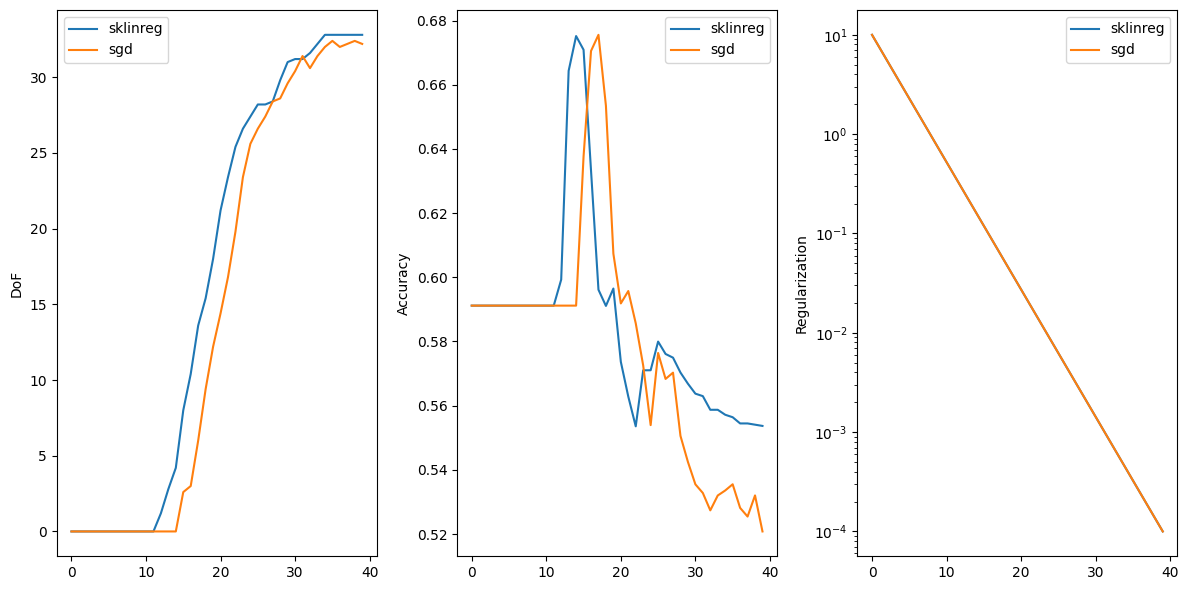

In [45]:
fig = plt.figure(figsize=(12,6))

steps = list(range(len(reg_params)))
legend = ["glmnet", "sklinreg", "sgd"]

p0 = fig.add_subplot(131)
#p0.plot(steps, glmnet_cv_res[("mean", "dof")], label=legend[0])
p0.plot(steps, sk_linreg_res[("mean", "dof")][::-1], label=legend[1])
p0.plot(steps, sgd_cv_res[("mean", "dof")], label=legend[2])
p0.set_ylabel("DoF")
p0.legend()

p1 = fig.add_subplot(132)
#p1.plot(steps, glmnet_cv_res[("mean", "accuracy")], label=legend[0])
p1.plot(steps, sk_linreg_res[("mean", "accuracy")][::-1], label=legend[1])
p1.plot(steps, sgd_cv_res[("mean", "accuracy")], label=legend[2])
p1.set_ylabel("Accuracy")
p1.legend()

p2 = fig.add_subplot(133)
#p2.plot(steps, glmnet_reg_params, label=legend[0])
p2.plot(steps, sk_reg_params, label=legend[1])
p2.plot(steps, sgd_reg_params, label=legend[2])
p2.set_yscale("log")
p2.set_ylabel("Regularization")
p2.legend()

fig.tight_layout()

## Run for 100 different Seeds

- compare parameters to R implementation